In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conn = sqlite3.connect("../db/baltasar.db")
def sql(query):
    #print(query)
    return pd.read_sql_query(query, conn)

In [3]:
sql('SELECT * FROM Address LIMIT 1')

,address,name,url,isExchange,isDepositAddress,isCappReceiver,isCappSender,isCappStorage,isCappOther,isOriginAddress,cluster
0,0x8e1b448ec7adfc7fa35fc2e885678bd323176e34,egretia,http://egretia.io/,0,0,0,0,0,0,0,0x8e1b448ec7adfc7fa35fc2e885678bd323176e34


## Iteration 1

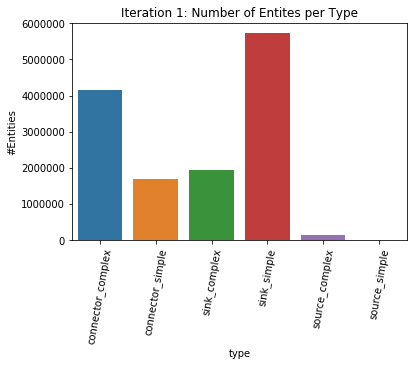

In [9]:
graphProperties = sql('''
SELECT "sink_simple" as type, count(*) as "#Entities" FROM EntityMetadata WHERE indegree = 1 and outdegree = 0
UNION
SELECT "sink_complex", count(*) FROM EntityMetadata WHERE indegree > 1 and outdegree = 0
UNION
SELECT "source_simple", count(*) FROM EntityMetadata WHERE indegree = 0 and outdegree = 1
UNION
SELECT "source_complex", count(*) FROM EntityMetadata WHERE indegree = 0 and outdegree > 1
UNION
SELECT "connector_simple", count(*) FROM EntityMetadata 
WHERE 
    indegree = 1 and outdegree = 1
UNION
SELECT "connector_complex", count(*) FROM EntityMetadata 
WHERE 
    indegree > 0 and outdegree > 0
''')
ax = sns.barplot(data=graphProperties, x='type', y='#Entities')
ax.set_title('Iteration 1: Number of Entites per Type')
plt.xticks(rotation=80)
plt.savefig('graphs/iter1.pdf')
plt.show()

In [11]:
graphProperties

,type,#Entities
0,connector_complex,4160266
1,connector_simple,1681459
2,sink_complex,1943297
3,sink_simple,5726386
4,source_complex,158433
5,source_simple,13005


## Iteration 2

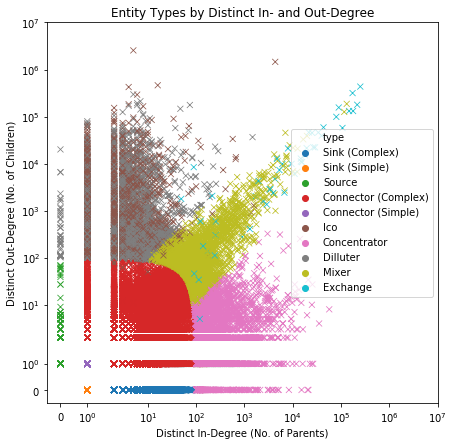

In [7]:
df = sql('''
SELECT m.distinctInDegree, m.distinctOutDegree, type
FROM
    EntityMetadata m
    INNER JOIN
    EntityTaxonomy t
ON
    m.name = t.name
WHERE m.distinctDegree > 100 or m.name LIKE "%F" 
''')
#df.loc[df['distinctInDegree'] == 0, ['distinctInDegree']] = 0.5
#df.loc[df['distinctOutDegree'] == 0, 'distinctOutDegree'] = 0.5

df['type'] = df['type'].apply(lambda p: prettify(p))
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="symlog", yscale="symlog")
sns.scatterplot(x='distinctInDegree', y='distinctOutDegree', hue="type", marker='x', data=df, ax=ax)
plt.title('Entity Types by Distinct In- and Out-Degree')
plt.xlabel('Distinct In-Degree (No. of Parents)')
plt.ylabel('Distinct Out-Degree (No. of Children)')
ax.set_xlim([-0.5,10**7])
ax.set_ylim([-0.5,10**7])

plt.savefig('graphs/tax_type.png', dpi=300)

# Iteration 3

ICOs, Capps and Exchanges were found before. We analyze them empirically to determine if they fit into the type dimension or should get other Dimensions. Thus, we chose empirical to conceptual.

In [25]:
sql('''
SELECT type, count(distinct Entity.name),sum(Entity.isExchange) FROM 
    (ICOAddress 
    NATURAL JOIN 
    Address)
    INNER JOIN
    (Entity
    NATURAL JOIN
    EntityTaxonomy)
    ON Entity.name = Address.cluster
GROUP BY type''')

,type,count(distinct Entity.name),sum(Entity.isExchange)
0,connector_complex,302,0
1,dilluter,2226,1
2,mixer,46,13


ICOs are in most cases dilluters, which makes sense as they sell tokens to a large audience. The included Mixers appear to be Initial Exchange Offerings, in which an exchange sells the token instead of a smart contract. The high number of connectors is surprising.

In [27]:
sql('''
SELECT type, count(distinct Entity.name), sum(Entity.isExchange)
FROM
    Address
    INNER JOIN
    (Entity
    NATURAL JOIN
    EntityTaxonomy)
    ON Address.cluster = Entity.name
WHERE Address.isCappReceiver = 1
GROUP BY type
''')

,type,count(distinct Entity.name),sum(Entity.isExchange)
0,concentrator,52,0
1,connector_complex,431,0
2,dilluter,11,0
3,mixer,415,180


Capps are most often mixers or complex connectors, dilluters and concentrators also exist.

In [21]:
sql('''
SELECT type, count(*)
FROM
    Entity
    NATURAL JOIN
    EntityTaxonomy
WHERE Entity.isExchange = 1
GROUP BY type''')

,type,count(*)
0,concentrator,1
1,connector_complex,9
2,dilluter,2
3,mixer,43
4,sink_complex,8
5,sink_simple,1


Exchanges were labelled by users of Etherscan. The sinks and connectors are Exchanges which do not trade tokens included in the dataset, but for example Ether for Bitcoin. Exchanges are most often mixers.

Conceptually, an ICO and an Exchange represent a type of entity which is fundamentally different from other addresses. An ICO or Exchange will interact with other entities similarly: In the case of an ICO, it will emit tokens to many addresses and in the case of the exchange, it will receive and send tokens from many different addresses. Therefore the two are included in the type dimension. However, it is important to note that in the labels only ICOs and Exchange that could definitely marked are included. It is very likely that dilluters and mixers include more entities which also are exchanges and ICOs respectively.

Initial Exchange Offerings are somewhat difficult to classify because they are exchanges and ICOs (by the definition in chapter \todo{}) at the same time. As they are foremost exchanges and only rarely perform ICOs, they are marked as exchanges.

Centralized Applications are defined by their use of deposit addresses. As shown in table \todo{}, they are often exchanges and often mixers. However, conceptually, a centralized application can also be used to collect funds and provide a service which would most likely form a Concentrator-like pattern. Therefore, the fact that an entity is a Capp is independent of it's type.

# Iteration 4

Conceptual: An entity can be
- empty
- active
- dormant

In [23]:
sql('''
SELECT 
    involumeUSD - outvolumeUSD BETWEEN -0.05 and 0.05 as empty, count(*) as cnt
FROM EntityMetadata
WHERE name LIKE "%F"
GROUP BY empty
''')

,empty,cnt
0,0,443920
1,1,304293


In [370]:
df = sql('''
SELECT 
    name, later.timestamp as lastTime, MAX(earlier.timestamp) as prevTime
FROM
    Entity e
    INNER JOIN
    ETransfer later
    INNER JOIN
    ETransfer earlier
    ON 
        (e.name = later.`from` OR e.name = later.`to`)
        AND
        (e.name = earlier.`from` OR e.name = earlier.`to`)
        AND
        later.blocknumber > earlier.blocknumber
WHERE name LIKE '%ABC'
GROUP BY name, later.blocknumber
''')

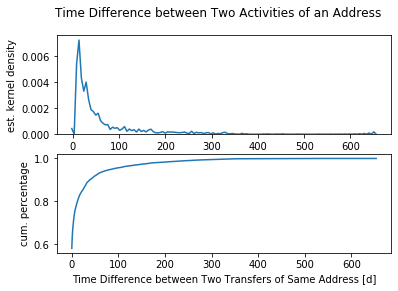

In [371]:
#sns.violinplot(data=df, x='diff')
df["lastDate"] = pd.to_datetime(df["lastTime"], unit='s')
df["prevDate"] = pd.to_datetime(df["prevTime"], unit='s')
df['diffInDays'] = (df['lastDate'] - df['prevDate']).apply(lambda d: d.days)
#
df_grouped = df.sort_values(by='diffInDays').groupby('diffInDays').count().reset_index()
df_grouped['perc'] = df_grouped['lastTime'] / df_grouped['lastTime'].sum()
df_grouped['perc_cum'] = df_grouped['perc'].cumsum()
#
f, axes = plt.subplots(2, 1)
sns.kdeplot(df['diffInDays'], ax=axes[0])
axes[0].set_ylabel('est. kernel density')
axes[0].set_xlabel('diff between two transfers [d]')
axes[0].get_legend().remove()
plt.suptitle('Time Difference between Two Activities of an Address')
sns.lineplot(data=df_grouped, x='diffInDays', y='perc_cum',ax=axes[1])
axes[1].set_ylabel('cum. percentage')
axes[1].set_xlabel('Time Difference between Two Transfers of Same Address [d]')

plt.savefig('graphs/tax_activeness.pdf')

58% of activities happened within 1 day, 75% of activities of an address happened within 7 days, 88% within 30 days. Therefore, we include the dimension activity, with the characteristics empty, daily, weekly, monthly active, inactive

## Iteration 5

Conceptual, an entity can have a certain age which indicates the time of its first activity

In [11]:
df = sql('''
SELECT 
    name, MIN(IFNULL(firstInTransfer,firstOutTransfer), IFNULL(firstOutTransfer, firstInTransfer)) as firstActivity
FROM
    EntityMetadata
WHERE name LIKE '%ABC'
''')

/root/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:317: RuntimeWarning: invalid value encountered in greater
  clip_x = np.logical_and(X > clip[0], X < clip[1])
/root/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:317: RuntimeWarning: invalid value encountered in less
  clip_x = np.logical_and(X > clip[0], X < clip[1])


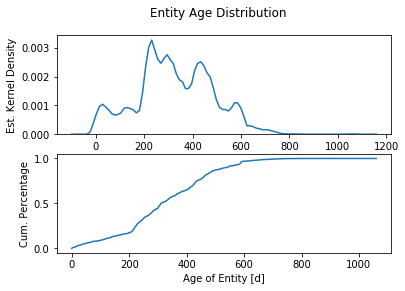

In [12]:
#sns.violinplot(data=df, x='diff')
df["firstDate"] = pd.to_datetime(df["firstActivity"], unit='s')
df['diffInDays'] = (df['firstDate'].max() - df['firstDate']).apply(lambda d: d.days)
#
df_grouped = df.sort_values(by='diffInDays').groupby('diffInDays').count().reset_index()
df_grouped['perc'] = df_grouped['firstDate'] / df_grouped['firstDate'].sum()
df_grouped['perc_cum'] = df_grouped['perc'].cumsum()
#
f, axes = plt.subplots(2, 1)
sns.kdeplot(df['diffInDays'], ax=axes[0],kernel='epa')
axes[0].set_ylabel('Est. Kernel Density')
axes[0].set_xlabel('Age of Entity [d]')
axes[0].get_legend().remove()
plt.suptitle('Entity Age Distribution')
sns.lineplot(data=df_grouped, x='diffInDays', y='perc_cum',ax=axes[1])
axes[1].set_ylabel('Cum. Percentage')
axes[1].set_xlabel('Age of Entity [d]')

plt.savefig('graphs/tax_age.pdf')

We characterize the age of an entity as
- week
- month
- quarter
- year
- over_year

## Iteration 6

I have monetary information we can use and an idea for a potential dimension. Therefore, I choose conceptual to empirical.

Entities are interested in making a financial profit. The profitability of an entity might therefore be a very interesting metric. I define profitability as: (current balance value + value of outgoing transfers at time of transfer) / value of incoming transfers at time of transfers

In [389]:
df = sql('''
SELECT profitability FROM EntityMetadata WHERE profitability is not null and name LIKE '%FF' and profitability < 5
''')

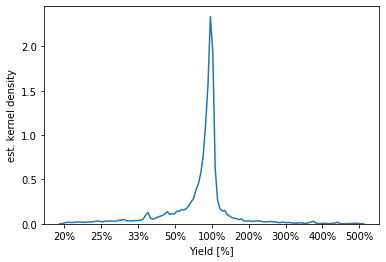

In [401]:
df['profitability_perc'] = df['profitability'] * 100
df['prof_transformed'] = df['profitability'] - 1
df.loc[df['prof_transformed'] < 0, 'prof_transformed'] = 1 + 1 / df['prof_transformed']

df_plot = df[df['prof_transformed'] > -4]


sns.kdeplot(df_plot['prof_transformed'])
plt.xticks(np.arange(-4, 5), ('20%', '25%','33%','50%','100%', '200%', '300%', '400%', '500%'))


axes = plt.gca()
axes.set_xlabel('Yield [%]')
axes.set_ylabel('est. kernel density')
axes.get_legend().remove()
plt.savefig('graphs/tax_yield.pdf')

## Iteration 7

In [44]:
df = sql('''
SELECT e.name, parentT.type
FROM 
    ((SELECT * FROM Entity ORDER BY name DESC LIMIT 1000000) e
    NATURAL JOIN
    EntityMetadata m)
    INNER JOIN
    ETransfer t
    INNER JOIN
    (Entity parent
    NATURAL JOIN
    EntityTaxonomy parentT)
    ON e.name = t.`to` and t.`from` = parent.name
GROUP BY e.name, parentT.type
HAVING sum(amountInUSDCurrent) > 0.75 * involumeUSD''')
aggr_parents = df.groupby('type').count().reset_index()
aggr_parents.loc[aggr_parents['name'] == 'various'] = 1000000 - df.shape[0]
aggr_parents = aggr_parents.append({'type' : 'various' , 'name' : 1000000 - df.shape[0]} , ignore_index=True)
#aggr


In [52]:
df = sql('''
SELECT e.name, childT.type
FROM 
    ((SELECT * FROM Entity ORDER BY name DESC LIMIT 1000000) e
    NATURAL JOIN
    EntityMetadata m)
    INNER JOIN
    ETransfer t
    INNER JOIN
    (Entity child
    NATURAL JOIN
    EntityTaxonomy childT)
    ON e.name = t.`from` and t.`to` = child.name
GROUP BY e.name, childT.type
HAVING sum(amountInUSDCurrent) > 0.75 * outvolumeUSD''')
#aggr_children75 = aggr_children
sinksCount = sql('''
    SELECT count(*)
    FROM
        (SELECT * FROM Entity LIMIT 1000000) e
        NATURAL JOIN
        EntityTaxonomy
    WHERE type = 'sink_complex' or type = 'sink_simple' ''')

num_sinks = sinksCount.values[0][0]

aggr_children = df.groupby('type').count().reset_index()
aggr_children = aggr_children.append({'type' : 'none' , 'name' : num_sinks} , ignore_index=True)
aggr_children = aggr_children.append({'type' : 'various' , 'name' : 1000000 - num_sinks - df.shape[0]}, ignore_index=True)
#aggr_children


## Iteration 8

Holding size

In [3]:
d = sql('''
SELECT 
    involumeUSD - outvolumeUSD as balance_unadjusted, 
    involumeUSD_adjusted - outvolumeUSD_adjusted as balance_adj, 
    1 as cnt,
    name
from 
    EntityMetadata 
WHERE name like '%e' and balance_unadjusted > 0
''')

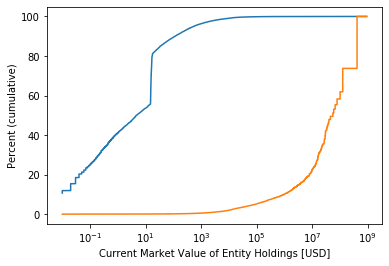

In [4]:
d['balance'] = d['balance_adj']
d.loc[d['balance'] < 0.01, 'balance'] = 0.01
df_grouped = d.sort_values(by='balance').groupby('balance').count().reset_index()
df_grouped['value'] = df_grouped['cnt'] * df_grouped['balance']
df_grouped['perc_addr'] = df_grouped['cnt'] / df_grouped['cnt'].sum() *100
df_grouped['perc_value'] = df_grouped['value'] / df_grouped['value'].sum() *100
df_grouped['perc_addr_cum'] = df_grouped['perc_addr'].cumsum()
df_grouped['perc_value_cum'] = df_grouped['perc_value'].cumsum()


g = sns.lineplot(data=df_grouped, x='balance', y='perc_addr_cum', drawstyle='steps-pre')
g = sns.lineplot(data=df_grouped, x='balance', y='perc_value_cum', drawstyle='steps-pre')
g.set_xscale("log")
g.set_xlabel('Current Market Value of Entity Holdings [USD]')
g.set_ylabel('Percent (cumulative)')
plt.savefig('graphs/tax_holding.pdf')


Some tokens report errours Transfer amounts which lead to invalid balance values. Examples for this are:
- 0xd6a09bdb29e1eafa92a30373c44b09e2e2e0651e, received "SmartMesh" Tokens with a value of 3 * 10^56 USD.
- 0x000000000000000000000048b21d0b13d6d40000, received "sharpe-platform-token" with a value of 4 * 10^26 USD.

In sum 30 entities have balances of more than 1 billion USD. The once examined seem to be associated with a single token. Some of them could be stores of tokens of the token emitters which they can later use to increase the number of available tokens.

In [10]:
sql('''SELECT involumeUSD - outvolumeUSD as balance, * FROM EntityMetadata WHERE balance > 1000000000 ORDER BY ABS(balance) DESC''')

,balance,name,indegree,outdegree,degree,distinctDegree,distinctInDegree,distinctOutDegree,involumeUSD,outvolumeUSD,firstInTransfer,firstOutTransfer,lastInTransfer,lastOutTransfer,profitability
0,3.285199e+56,0xd6a09bdb29e1eafa92a30373c44b09e2e2e0651e,1,10,11,6,1,5,3.285199e+56,6.549777e+17,1524598859,1.524599e+09,1524598859,1.524603e+09,0.090787
1,4.451103e+26,0x000000000000000000000048b21d0b13d6d40000,1,1,2,2,1,1,4.451103e+26,5.264791e+16,1517001724,1.517005e+09,1517001724,1.517005e+09,NaN
2,6.549771e+17,0x5faf679d017438f481faf55e0f0cac3998ed1c88,2,0,2,1,1,0,6.549771e+17,0.000000e+00,1524599370,NaN,1524600091,NaN,0.090787
3,6.484921e+17,0x80c0f1ba0e243f5c5c8cc45e0d6c95ce1cbff41b,1,15,16,4,1,3,6.484921e+17,2.828544e+05,1524599535,1.524600e+09,1524599535,1.524604e+09,0.090787
4,6.484921e+16,0xe29526b6d7def7433823851c25f36a365567165f,1,5,6,6,1,5,6.484921e+16,1.478562e+04,1524599400,1.524600e+09,1524599400,1.524607e+09,0.090787
5,6.484921e+13,0x38c1617864cbab17a5e4078ffd37a587ef0d4236,5,1,6,5,4,1,6.484921e+13,2.104600e+02,1518570334,1.518571e+09,1538089386,1.518571e+09,0.090787
6,6.484921e+11,0xb4d30cac5124b46c2df0cf3e3e1be05f42119033,1,0,1,1,1,0,6.484921e+11,0.000000e+00,1524599264,NaN,1524599264,NaN,0.090787
7,7.542159e+09,0xb1f5f4d8f4baeffa8dc3ac37e5fb11d7a989e5cd,2,9,11,9,2,7,1.508583e+10,7.543667e+09,1542891127,1.547555e+09,1552971555,1.556098e+09,NaN
8,5.663653e+09,0x9581973c54fce63d0f5c4c706020028af20ff723,1,22,23,12,1,11,6.133150e+09,4.694965e+08,1517587774,1.519231e+09,1517587774,1.547056e+09,NaN
9,3.771457e+09,0xf3816cd92f89ec7abbba8f418c1429add7ab1eaa,1,0,1,1,1,0,3.771457e+09,0.000000e+00,1547554640,NaN,1547554640,NaN,NaN


The reported total supply according to coinmarketcap and the actual supply is different. For 49 tokens the balances are more than twice the amounts reported in CoinMarketCap. The token smartmesh has 1.6 * 10^49 more tokens than reported. A 67 tokens have fewer tokens than 50% of the actual total supply.

A new column for account balances which is not including the 49 tokens with a too high ratio is created.

In [25]:
sql('''SELECT *, actualSupply * 1.0 / reportedSupply as supplyRatio FROM Token WHERE supplyRatio > 1.5 and actualSupply <> "NOT INCLUDED"''')

,id,decimals,name,address,reportedSupply,actualSupply,excludeFromAdjustedVolumes,supplyRatio
0,quant,18,Quant,0x4a220e6096b25eadb88358cb44068a3248254675,1.461249e+07,2.443126e+07,0,1.671943e+00
1,revain,0,Revain,0x48f775efbe4f5ece6e0df2f7b5932df56823b990,4.844500e+08,1.004857e+09,1,2.074222e+00
2,bit-z-token,18,Bit-Z Token,0x4375e7ad8a01b8ec3ed041399f62d9cd120e0063,6.843071e+08,1.200000e+09,0,1.753599e+00
3,utrust,18,UTRUST,0x70a72833d6bf7f508c8224ce59ea1ef3d0ea3a38,5.000000e+08,1.000000e+09,1,2.000000e+00
4,smartmesh,18,SmartMesh,0x55f93985431fc9304077687a35a1ba103dc1e081,3.141593e+09,5.065904e+58,1,1.612527e+49
5,noah-coin,18,Noah Coin,0x58a4884182d9e835597f405e5f258290e46ae7c2,9.158400e+10,2.035833e+11,1,2.222913e+00
6,napoleonx,2,NaPoleonX,0x28b5e12cce51f15594b0b91d5b5adaa70f684a02,2.980000e+07,5.889574e+07,0,1.976367e+00
7,v-id,18,V-ID,0x445f51299ef3307dbd75036dd896565f5b4bf7a5,6.269979e+07,1.000000e+08,0,1.594902e+00
8,polybius,6,Polybius,0x0affa06e7fbe5bc9a764c979aa66e8256a631f02,3.969565e+06,2.024650e+07,1,5.100433e+00
9,penta,18,Penta,0x53066cddbc0099eb6c96785d9b3df2aaeede5da3,5.000000e+10,9.948141e+10,0,1.989628e+00


We can therefore group addresses by the holding size into:
- origin (under -1 USD)
- empty
- under 1 USD
- 1 USD to 10 USD
- 10 USD to 100 USD
- 100 USD to 1000 USD
- 1000 USD to 10000 USD
- 10000 USD to 1'000'000 USD
- \> 1'000'000 USD

# Iteration 9
Number of Tokens Used

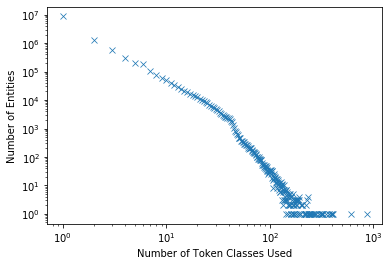

In [39]:
data = sql('''
SELECT numTokens, count(*) as numEntities
FROM
(SELECT count(distinct token) as numTokens
FROM ETransfer e
GROUP BY e.`to`) x
GROUP BY numTokens
''')

g = sns.scatterplot(data=data, x='numTokens', y='numEntities', marker='x')
g.set_xscale("log")
g.set_yscale("log")
g.set_xlabel('Number of Token Classes Used')
g.set_ylabel('Number of Entities')

plt.savefig('graphs/tax_num_tokens.pdf')

Number of Tokens
- 1
- 2
- 3-6
- 6-30
- \>30

# Interlude

In [9]:
columns = ['type', 'operator', 'age', 'activeness', 'yield', 'parents', 'children', 'holdingSize', 'numberOfTokens']
#columns = ['holdingSize']
columnsSortBy = {
    'type': {
        'col': 'dimension',
        'ascending': False
    },
    'operator': {
        'col': 'dimension',
        'ascending': False
    },
    'age': {
        'useOrder': True,
        'col': 'dimension_ordered',
        'ascending': True   
    },
    'activeness': {
        'col': 'percEntities',
        'ascending': True
    },
    'yield': {
        'col': 'dimension',
        'ascending': True
    },
    'parents': {
        'col': 'dimension',
        'ascending': False
    },
    'children': {
        'col': 'dimension',
        'ascending': False
    },
    'holdingSize': {
        'useOrder': True,
        'col': 'dimension_ordered',
        'ascending': True
    },
    'numberOfTokens': {
        'col': 'percEntities',
        'ascending': False
    }    
}

order = {
    "under_1USD": 1,
    "under_10USD": 2,
    "under_100USD": 3,
    "under_1kUSD": 4,
    "under_10kUSD": 5,
    "under_1kkUSD": 6,
    "over_1kkUSD": 7,
    "empty": 0,
    'origin': 8,
    "week": 1,
    "month": 2,
    "quarter": 3,
    "year": 4,
    "over1Year": 5,
    "unknown": 0
}

nameChanges = {
    'numberOfTokens':'Number Of \\\\ Token Classes',
    'holdingSize': 'Holding Size',
    'loss<.1': 'Loss <10\\%',
    "loss<.67": 'Loss <67\\%',
    "loss<.9": 'Loss <90\\%',
    "steady>=.9,<1.1": 'Steady >=90\\%, <110\\%',
    "profit<1.5": 'profit <150\\%',
    "profit<10": 'profit <1\\,000\\%',
    "profit>=10": 'profit >=1\\,000\\%',
    "under_1USD": 'under 1 USD',
    "under_10USD": 'under 10 USD',
    "under_100USD": 'under 100 USD',
    "under_1kUSD": 'under 1\\,000 USD',
    "under_10kUSD": 'under 10\\,000 USD',
    "under_1kkUSD": 'under 1\,000\\,000 USD',
    "over_1kkUSD": '1\\,000\\,000 USD or more',
    "over1Year": 'Over 1 Year',
    "capp": "Deposit-Address-based"
}

def getResults(column):
    df = sql('''
    SELECT 
        t.'''+column+''' as dimension, 
        count(*) as numEntities,
        SUM(CASE 
        WHEN involumeUSD_highcap > outvolumeUSD_highcap THEN involumeUSD_highcap - outvolumeUSD_highcap
        ELSE 0 END) as capitalization
    FROM 
        EntityTaxonomy t
        INNER JOIN
        (SELECT * FROM EntityMetadata m LIMIT 10000) m
    ON
        t.name = m.name
    GROUP BY t.'''+column)
    df['percEntities'] = df['numEntities'] / df['numEntities'].sum()
    df['percCapitalization'] = df['capitalization'] / df['capitalization'].sum()
    
    if 'useOrder' in columnsSortBy[column]:
        df['dimension_ordered'] = df['dimension'].apply(lambda d:order[d])
    
    df_sorted = df.sort_values(by=columnsSortBy[column]['col'], ascending=columnsSortBy[column]['ascending'])
    return df_sorted

def getResultsTokenLevel(column):
    df = sql('''
    SELECT 
        t.'''+column+''' as dimension, 
        count(*) as numEntities,
        sum(IFNULL(percentage,0)) as percCapitalization
    FROM 
        (SELECT * FROM EntityTaxonomy) t
        LEFT OUTER JOIN
        TokenBalance b
    ON
        t.name = b.name
    WHERE 
         b.token is null or b.token = 'ALL_ADJUSTED' 
    GROUP BY t.'''+column)
    df['percEntities'] = df['numEntities'] / df['numEntities'].sum()
    if 'useOrder' in columnsSortBy[column]:
        df['dimension_ordered'] = df['dimension'].apply(lambda d:order[d])
    
    df_sorted = df.sort_values(by=columnsSortBy[column]['col'], ascending=columnsSortBy[column]['ascending'])
    return df_sorted

def prettify(rawColumnName):
    if rawColumnName in nameChanges:
        rawColumnName = nameChanges[rawColumnName]
    if '_' in rawColumnName:
        rawColumnName = rawColumnName.split('_')[0] + ' ('+rawColumnName.split('_')[1]+")"
    return rawColumnName.title()

def getTabularxRow(column):
    res = getResultsTokenLevel(column)
    res['p1'] = res['percEntities'].apply(lambda p: str(int(round(p, 2)*100))+"\%")
    res['p2'] = res['percCapitalization'].apply(lambda p: str(int(round(p, 2)*100))+"\%")
    pre = "\\makecell{"+prettify(column)+"} & " 
    cells = res[['dimension','p1','p2']].apply(lambda p: prettify(p[0])+"\\\\ ("+p[1]+", "+p[2]+")", axis=1)
    cells = cells.apply(lambda c: "\\hfill \\makecell{"+c+"}")
    main = "".join(cells)
    post = "\\hfill\\null \\\\"
    line = (pre + main + post).replace('Usd', 'USD').replace('Ico', 'ICO').replace(' 0\%', ' <1\%').replace('(0\%', '(<1\%')
    return line

def makeTabularx():
    print('''\\begin{landscape}
\\begin{table}[]''')
    print('\\begin{tabularx}{\linewidth}{|c||X|}')
    print('\\toprule')
    print('Dimension & \\hfill Characteristics \\hfill\\null \\\\')
    print('\\midrule')
    print('\\midrule')
    for column in columns:
        print(getTabularxRow(column))
        print('\\midrule')
    print('\\bottomrule')
    print('''\end{tabularx}
\end{table}
\end{landscape}''')    


In [10]:
makeTabularx()

\begin{landscape}
\begin{table}[]
\begin{tabularx}{\linewidth}{|c||X|}
\toprule
Dimension & \hfill Characteristics \hfill\null \\
\midrule
\midrule
\makecell{Type} & \hfill \makecell{Source\\ (2\%, <1\%)}\hfill \makecell{Sink (Simple)\\ (46\%, 25\%)}\hfill \makecell{Sink (Complex)\\ (16\%, 11\%)}\hfill \makecell{Mixer\\ (<1\%, 5\%)}\hfill \makecell{ICO\\ (<1\%, 5\%)}\hfill \makecell{Exchange\\ (<1\%, 11\%)}\hfill \makecell{Dilluter\\ (<1\%, 1\%)}\hfill \makecell{Connector (Simple)\\ (17\%, 4\%)}\hfill \makecell{Connector (Complex)\\ (19\%, 37\%)}\hfill \makecell{Concentrator\\ (<1\%, 2\%)}\hfill\null \\
\midrule
\makecell{Operator} & \hfill \makecell{Other\\ (100\%, 88\%)}\hfill \makecell{Deposit-Address-Based\\ (<1\%, 12\%)}\hfill\null \\
\midrule
\makecell{Age} & \hfill \makecell{Unknown\\ (<1\%, <1\%)}\hfill \makecell{Week\\ (1\%, 1\%)}\hfill \makecell{Month\\ (2\%, 3\%)}\hfill \makecell{Quarter\\ (4\%, 9\%)}\hfill \makecell{Year\\ (53\%, 39\%)}\hfill \makecell{Over 1 Year\\ (39\%, 

In [9]:

sql('''
SELECT 
        t.age as dimension, 
        count(*) as numEntities,
        sum(IFNULL(percentage,0)) as percCapitalization
    FROM 
        (SELECT * FROM EntityTaxonomy LIMIT 10000) t
        LEFT OUTER JOIN
        TokenBalance b
    ON
        t.name = b.name
    WHERE 
         b.token is null or b.token = 'ALL_ADJUSTED' 
    GROUP BY t.age''')

,dimension,numEntities,percCapitalization
0,month,91,2.573916e-06
1,over1Year,3522,2.310703e-03
2,quarter,334,3.019707e-05
3,week,151,8.453249e-07
4,year,5827,3.367882e-04
